# Модель для определения рыночной стоимости автомобиля

**Описание задачи:** Нужно построить модель для определения рыночной стоимости автомобилей с пробегом. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

Заказчику важны:

- качество предсказания
- скорость предсказания
- время обучения.

* [1. Подготовка данных](#first_bullet)
    * [1.1. Импорт библиотек](#second_bullet)
    * [1.2. Чтение файла и изучение данных](#third_bullet)
    * [1.3. Предобработка данных](#fourth_bullet)
        * [Обработка дубликатов](#fifth_bullet)
        * [Отсев лишних признаков](#sixth_bullet)
        * [Обработка пропусков](#seventh_bullet)
        * [Замена типа данных для категориальных переменных](#eighth_bullet)
        * [Обработка численных признаков](#ninth_bullet)
* [2. Обучение моделей](#tenth_bullet)
    * [2.1. Подготовка данных](#eleventh_bullet)
        * [2.1.1. Преобразование признаков](#twelfth_bullet)
        * [2.1.2. Разбиение данных на выборки](#thirteenth_bullet)
        * [2.1.3. Масштабирование признаков](#fourteenth_bullet)
    * [2.2. Обучение разных моделей](#sixteenth_bullet)
        * [2.2.1. LinearRegression](#seventeenth_bullet)
        * [2.2.2. LGBMRegressor](#eighteenth_bullet)
        * [2.2.3. CatBoostRegressor](#nineteenth_bullet)
* [3. Анализ моделей и вывод](#twentieth_bullet)

# 1. Подготовка данных<a id="first_bullet"></a>

### 1.1. Импорт библиотек<a id="second_bullet"></a>

In [1]:
! pip install catboost

In [2]:
! pip install lightgbm

In [3]:
from catboost import CatBoostRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import time

import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, HTML, Image
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', -1)

In [4]:
!pip3 install seaborn==0.11.0 
import seaborn as sns
sns.set_style('darkgrid')

### 1.2. Чтение файла и изучение данных<a id="third_bullet"></a>

Прочитаем файл и сохраним данные в переменной *data*.

In [5]:
data = pd.read_csv('autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Выведем на экран общую информацию о датафрейме.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Датафрейм содержит следующие данные: 

**Признаки:**

- дата скачивания анкеты из базы
- тип автомобильного кузова
- год регистрации автомобиля
- тип коробки передач
- мощность (л. с.)
- модель автомобиля
- пробег (км)
- месяц регистрации автомобиля
- тип топлива
- марка автомобиля
- была машина в ремонте или нет
- дата создания анкеты
- количество фотографий автомобиля
- почтовый индекс владельца анкеты (пользователя)
- дата последней активности пользователя

**Целевой признак:**
- цена (евро)

Можно отметить, что:
- датафрейм содержит как количественные, так и качественные признаки
- в данных есть пропуски
- можно удалить такие признаки как `DateCrawled`, `RegistrationMonth` (сохраним признак с годом регистрации, а этот удалим, так как мало вероятно, что месяц регистрации будет сильно влиять на цену автомобиля), `DateCreated`, `NumberOfPictures` (этот признак содержит только 0), `PostalCode` и `LastSeen`. Они не играют важную роль при определении цены автомобиля.

Можем перейти к предобработке данных.

### 1.3. Предобработка данных<a id="fourth_bullet"></a>

**Обработка дубликатов**<a id="fifth_bullet"></a>

Проверим данные на дубликаты.

In [7]:
print('К-во дубликатов:', data.duplicated().sum())

К-во дубликатов: 4


В датафрейме есть дубликаты. Выведем их на экран и обработаем. 

In [8]:
data[data.duplicated() == True]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Удалим дубликаты. 

In [9]:
data.drop_duplicates(inplace=True)
print('К-во дубликатов:', data.duplicated().sum())

К-во дубликатов: 0


**Отсев лишних признаков**<a id="sixth_bullet"></a>

Удалим из датасета ненужные признаки. 

In [10]:
df = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


**Обработка пропусков**<a id="seventh_bullet"></a>

Посмотрим, сколько пропусков содержит каждый из признаков. 

In [11]:
d = {'К-во пропусков': df.isnull().sum(), 'Доля пропусков, %': df.isnull().sum() / len(df) * 100} 
pd.DataFrame(d)

,К-во пропусков,"Доля пропусков, %"
Price,0,0.000000
VehicleType,37490,10.579487
RegistrationYear,0,0.000000
Gearbox,19833,5.596772
Power,0,0.000000
Model,19705,5.560651
Kilometer,0,0.000000
FuelType,32895,9.282802
Brand,0,0.000000
NotRepaired,71154,20.079297


Видим, что доля пропусков в признаках с пропусками составляет от 5-20%, что достаточно много. Взглянем на признаки с пропусками более подробно. 

In [12]:
for col in df.columns:
    if df[col].isnull().sum() > 0:
        print(col)
        print(df[col].value_counts())
        print('\n')

VehicleType
sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other          3288 
Name: VehicleType, dtype: int64


Gearbox
manual    268249
auto      66283 
Name: Gearbox, dtype: int64


Model
golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2               8    
serie_3               4    
rangerover            4    
serie_1               2    
range_rover_evoque    2    
Name: Model, Length: 250, dtype: int64


FuelType
petrol      216349
gasoline    98719 
lpg         5310  
cng         565   
hybrid      233   
other       204   
electric    90    
Name: FuelType, dtype: int64


NotRepaired
no     247158
yes    36053 
Name: NotRepaired, dtype: int64




В данной ситуации, когда имеем большое к-во пропусков и категорий, можно ввести новую категорию, например *unknown* и заполнить пропуски ею.

In [13]:
for col in df.columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna('unknown', inplace=True)
        
        print(col)
        print(df[col].value_counts(normalize=True)*100)
        print('\n')

VehicleType
sedan          25.808700
small          22.527620
wagon          18.389231
unknown        10.579487
bus            8.120159 
convertible    5.701184 
coupe          4.560552 
suv            3.385210 
other          0.927857 
Name: VehicleType, dtype: float64


Gearbox
manual     75.698503
auto       18.704725
unknown    5.596772 
Name: Gearbox, dtype: float64


Model
golf                  8.249122
other                 6.891200
3er                   5.576454
unknown               5.560651
polo                  3.687159
                        ...   
serie_2               0.002258
serie_3               0.001129
rangerover            0.001129
range_rover_evoque    0.000564
serie_1               0.000564
Name: Model, Length: 251, dtype: float64


FuelType
petrol      61.052587
gasoline    27.858000
unknown     9.282802 
lpg         1.498455 
cng         0.159440 
hybrid      0.065751 
other       0.057568 
electric    0.025398 
Name: FuelType, dtype: float64


NotRepaired
no  

**Замена типа данных для категориальных переменных**<a id="eighth_bullet"></a>

In [14]:
cols_cat = df.select_dtypes(include='object').columns
for col in cols_cat:
    df[col] = df[col].astype('category')

Проверка результата.

In [15]:
df.dtypes

Price               int64   
VehicleType         category
RegistrationYear    int64   
Gearbox             category
Power               int64   
Model               category
Kilometer           int64   
FuelType            category
Brand               category
NotRepaired         category
dtype: object

**Обработка численных признаков**<a id="ninth_bullet"></a>

Исследуем более подробно каждый из численных признаков и удалим аномалии, если обнаружим их. 

In [16]:
df.describe(percentiles=np.arange(0,1,0.05))

,Price,RegistrationYear,Power,Kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
0%,0.000000,1000.000000,0.000000,5000.000000
5%,200.000000,1992.000000,0.000000,40000.000000
10%,499.000000,1995.000000,0.000000,70000.000000
15%,650.000000,1997.000000,54.000000,80000.000000
20%,880.000000,1998.000000,60.000000,100000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000


Для признаков *Price*, *Power* и *Kilometer* построим графики распределение. 

In [17]:
def viz_distribution(col, col_name):
    
    '''
    Функция как аргумент принимает признак и его название. 
    Функция возвращает информацию о распределении признака.  
    '''
    
    sns.displot(x = col, legend=True, kde=True, height=5.7, aspect=1.5, bins=100)
    plt.title('Распределение значений признака ' + str(col_name).title(), fontsize=16)

    plt.figure(figsize=(9.7, 6))
    sns.boxplot(y=col)

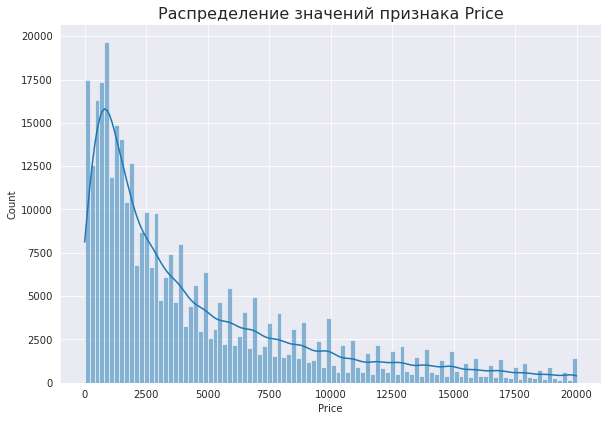

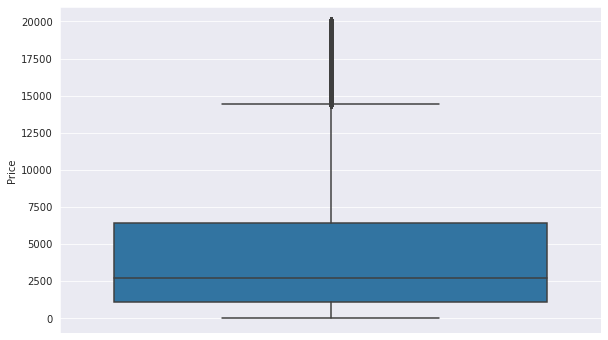

In [18]:
viz_distribution(df['Price'], 'Price')

Аномальными можно считать объекты с ценой меньше 200 денежных единиц и выше ~15к денежных единиц. Как видим, таких данных почти 10%, что достаточно много.  

In [19]:
print('Доля аномалий:', len(df.query('Price < 200 or Price >14600')) / len(df) *100)

Доля аномалий: 9.9089921408717


Удалим аномальные объекты из датафрейма и сохраним результат в переменной *clean_data*. 

In [20]:
clean_data = df.query('Price >= 200 or Price <=15000')

Исследуем признак *Power*. 

(-10.0, 1000.0)

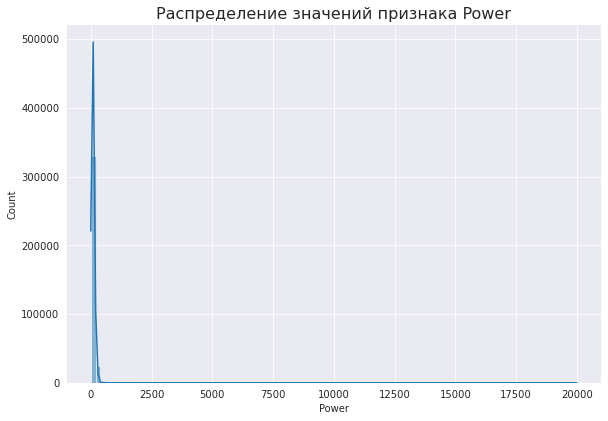

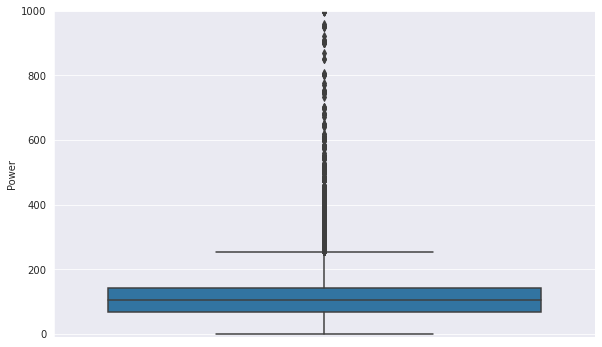

In [21]:
viz_distribution(df['Power'], 'Power')
plt.ylim(-10, 1000)

Видим, что аномальными можно считать объекты с мощностью больше 218 л.с. Также важно отметить, что этот признак содержит большое количество объектов со значением 0. Скорее всего, владелец автомобиля, при заполнинии анкеты, посто не указал мощность своего автомобиля, поэтому эти 0 можно воспринимать как пропуски и заменить на медиану, в зависимости от таких признаков как *Brand*, *Model* и *FuelType*. 

In [22]:
clean_data['Power'] = clean_data['Power'].replace(0, np.nan)
median = clean_data.groupby(['Brand', 'Model', 'FuelType'])['Power'].transform('median')
clean_data['Power'] = clean_data['Power'].fillna(median)

Проверим к-во объектов без информации о мощности автомобиля.

In [23]:
print('К-во пропусков:', clean_data['Power'].isnull().sum())

К-во пропусков: 100


Удалим эти строки. 

In [24]:
clean_data.dropna(inplace=True)
clean_data.isnull().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

Исследуем более подробно признак *Kilometer*.

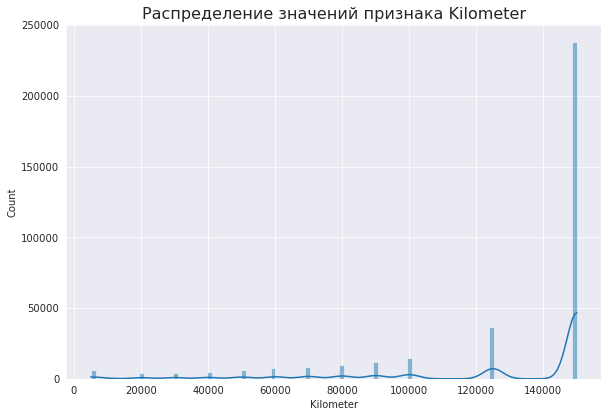

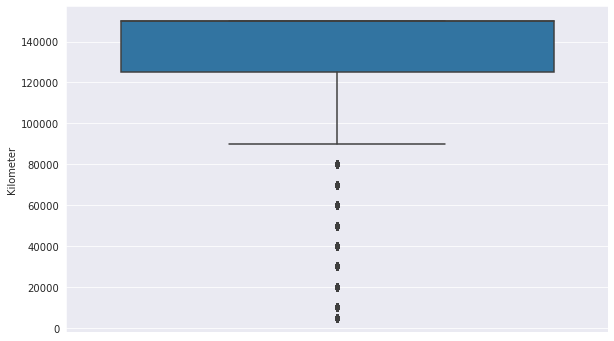

In [25]:
viz_distribution(df['Kilometer'], 'Kilometer')

Учитывая, что на продажу выставлены самые разные автомобили (новые, старые, дорогие, дешевые) и пробег у них может быть абсолютно разным, этот признак трогать не будем.

Тут интересно отметить, что медиана признака *Kilometer* - это одновременно и максимальный зафиксированный пробег. Возможно это как-то связано с ограничением анкеты, например, в анкете нельзя ввести более высокий показатель. Еще стоит отметить, что данный признак распределен дискретно и, по сути, можем его отнести к категориальными признаками.

С признаком *RegistrationYear* будем поступать следующим образом: так как нам неизвестно, о какой стране предоставлены данные и мы не можем узнать год, когда был зарегистрирован первый автомобиль в этой стране, будем считать, что год регистрации автомобиля не может быть меньше 1768 (если верить Википедии, то история первого автомобиля началась в 1768 году вместе с созданием паросиловых машин, способных перевозить человека) и больше 2020. 

In [26]:
clean_data = clean_data.query('RegistrationYear > 1768')
len(clean_data)

354204

**Результат:**

На этом этапе провели предобработку данных, а именно:
- удалили дубликаты
- заполнили пропуски
- обработали и проанализировали количественные признаки
- отчистили датасет от аномальных значений. 

Переходим к обучению модели. 

# 2. Обучение моделей<a id="tenth_bullet"></a>

На этом этапе проекта обучим разные модели:
- LinearRegression
- LGBMRegressor
- CatBoostRegressor.

Так как будем обучать и модель линейной регрессии, категориальные признаки необходимо преобразовать в численные.

## 2.1. Подготовка данных<a id="eleventh_bullet"></a>

### 2.1.1. Преобразование признаков<a id="twelfth_bullet"></a>

Для того, чтобы преобразовать категориальные признаки в численные, вызовем функцию *get_dummies()* с аргументом *drop_first*. Такой подход позволит не попасть в дамми-ловушку, так как не создает большое количество фиктивных признаков.

In [27]:
df_ohe = pd.get_dummies(clean_data, drop_first=True)
df_ohe.head()

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,Gearbox_manual,Gearbox_unknown,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,...,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknown,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,480,1993,90.0,150000,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,18300,2011,190.0,125000,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163.0,125000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75.0,150000,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69.0,90000,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


Признаков получилось достаточно много, что, безусловно, будет влиять на работу будущих моделей. 

### 2.1.2. Разбиение данных на выборки<a id="thirteenth_bullet"></a>

Так как спрятанной тестовой выборки у нас нету, разделим исходные данные на три выборки: обучающую, валидационную и тестовую. Так как размеры тестовой и валидационной выборок обычно равны, разделим данные в соотношении 3:1:1.

Для этого методом *train_test_split* разделим исходные данные на обучающую (60%) и валидационную выборку (40%), а после этого валидационную выборку разделим пополам — на валидационную и тестовую выборки.

In [28]:
target = df_ohe['Price']
features = df_ohe.drop('Price', axis=1)

In [29]:
features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              train_size=0.60, 
                                                                              test_size=0.40, 
                                                                              random_state=123)

In [30]:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            train_size=0.50, 
                                                                            test_size=0.50, 
                                                                            random_state=123)

Проверка результата.

In [31]:
samples = {'Размер обучающей выборки' : features_train, 
          'Размер валидационной выборки': features_valid, 
          'Размер тестовой выборки': features_test}

for key, value in samples.items():
    print(key + ':', value.shape)

Размер обучающей выборки: (212522, 311)
Размер валидационной выборки: (70841, 311)
Размер тестовой выборки: (70841, 311)


### 2.1.3. Масштабирование признаков<a id="fourteenth_bullet"></a>

Приведем признаки к одному масштабу. Для этого будем использовать структуру для стандартизации данных *StandardScaler*.

In [32]:
numeric = ['RegistrationYear', 'Power', 'Kilometer']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [33]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Проверка результата.

In [34]:
features_train.sample()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,Gearbox_manual,Gearbox_unknown,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,...,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknown,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
137756,-0.060021,-0.248216,0.574387,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Сейчас признаки имеют одинаковый масштаб. 

Перед тем как перейти к обучению моделей, напишем функцию для расчета метрики *RMSE*. Данная метрика позволит оценить и сравнить качество разных моделей. 

In [35]:
def rmse(target, predictions):
    mse = mean_squared_error(target, predictions)
    rmse = sqrt(mse)
    return rmse

Переходим к оюучению моделей. 

## 2.2. Обучение разных моделей<a id="sixteenth_bullet"></a>

### 2.2.1. LinearRegression<a id="seventeenth_bullet"></a>

Обучим модель линейной регрессии. Оценим время обучения и скорость и качество предсказания (RMSE). 

In [36]:
model_lr = LinearRegression()

In [37]:
start = time.time() 
model_lr.fit(features_train, target_train)
end_time_fit = time.time() - start
print('End time: ', end_time_fit)

End time:  5.575666666030884


In [38]:
start = time.time() 
predictions_lr = model_lr.predict(features_valid)
end_time_predict = time.time() - start

In [39]:
print('RMSE на валидационной выборке:', rmse(target_valid, predictions_lr))

RMSE на валидационной выборке: 3192.269975641005


In [40]:
results = []
results.append({'Модель': 'LinearRegression', 
                'Параметры': np.nan, 
                'Время обучения': end_time_fit, 
                'Скорость предсказания': end_time_predict, 
                'RMSE': rmse(target_valid, predictions_lr)})

pd.DataFrame(results)

,Модель,Параметры,Время обучения,Скорость предсказания,RMSE
0,LinearRegression,NaN,5.575667,0.098102,3192.269976


### 2.2.2. LGBMRegressor<a id="eighteenth_bullet"></a>

Обучим модель *LGBMRegressor*.

Подберем гиперпараметры и обучим модель. 

In [41]:
parameters = {'boosting_type': 'gbdt', 
              'max_depth': 11, 
              'n_estimators': 120, 
              'random_state': 123}

In [42]:
model_lgbm = LGBMRegressor(**parameters)

In [43]:
start = time.time() 
model_lgbm.fit(features_train, target_train)
end_time_fit = time.time() - start
print('End time: ', end_time_fit)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
End time:  2.0457241535186768


In [44]:
start = time.time() 
predictions_lgbm = model_lgbm.predict(features_valid, verbose=2)
end_time_predict = time.time() - start
print('End time: ', end_time_predict)

End time:  0.3385293483734131


In [45]:
print('RMSE на валидационной выборке:', rmse(target_valid, predictions_lgbm))

RMSE на валидационной выборке: 1824.1940300689353


In [46]:
results.append({'Модель': 'LGBMRegressor', 
                'Параметры': parameters, 
                'Время обучения': end_time_fit, 
                'Скорость предсказания': end_time_predict, 
                'RMSE': rmse(target_valid, predictions_lgbm)})

pd.DataFrame(results)

,Модель,Параметры,Время обучения,Скорость предсказания,RMSE
0,LinearRegression,NaN,5.575667,0.098102,3192.269976
1,LGBMRegressor,"{'boosting_type': 'gbdt', 'max_depth': 11, 'n_estimators': 120, 'random_state': 123}",2.045724,0.338529,1824.194030


Метрика *RMSE* у модели *LGBMRegressor* значительно ниже, чем у модели линейной регрессии, время обучения - выше, но скорость предсказания лучше.  

Обучим модель *CatBoostRegressor*. 

### 2.2.3. CatBoostRegressor<a id="nineteenth_bullet"></a>

In [47]:
for iteration in range(10, 101, 20):
    
    for depth in range(5, 11, 2):
    
        model_cbr = CatBoostRegressor(random_state=123, iterations=iteration, loss_function='RMSE', depth=depth)
    
        start = time.time() 
        model_cbr.fit(features_train, target_train)
        end_time_fit = time.time() - start

        start = time.time() 
        predictions_cbr = model_cbr.predict(features_valid, verbose=1)
        end_time_predict = time.time() - start

        RMSE = rmse(target_valid, predictions_cbr)
    
        results.append({'Модель': 'CatBoostRegressor', 
                        'Параметры': {'random_state':123, 
                                      'iterations': iteration, 
                                      'loss_function': 'RMSE', 
                                      'depth': depth}, 
                        'Время обучения': end_time_fit, 
                        'Скорость предсказания': end_time_predict, 
                        'RMSE': RMSE})

Learning rate set to 0.5
0:	learn: 3308.9708794	total: 79.6ms	remaining: 716ms
1:	learn: 2779.3722519	total: 113ms	remaining: 450ms
2:	learn: 2559.8854017	total: 150ms	remaining: 350ms
3:	learn: 2403.0374776	total: 194ms	remaining: 291ms
4:	learn: 2321.3132348	total: 234ms	remaining: 234ms
5:	learn: 2266.2636698	total: 262ms	remaining: 175ms
6:	learn: 2229.6917866	total: 288ms	remaining: 123ms
7:	learn: 2193.9722476	total: 317ms	remaining: 79.2ms
8:	learn: 2174.4736916	total: 353ms	remaining: 39.2ms
9:	learn: 2153.4721092	total: 390ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3198.1068677	total: 20.9ms	remaining: 188ms
1:	learn: 2671.2969237	total: 41ms	remaining: 164ms
2:	learn: 2418.8192222	total: 62.2ms	remaining: 145ms
3:	learn: 2293.1972363	total: 81.5ms	remaining: 122ms
4:	learn: 2206.4408034	total: 100ms	remaining: 100ms
5:	learn: 2155.1205699	total: 125ms	remaining: 83.5ms
6:	learn: 2123.7168271	total: 154ms	remaining: 66ms
7:	learn: 2090.1240146	total: 180ms	remaining:

33:	learn: 1948.2392213	total: 531ms	remaining: 250ms
34:	learn: 1942.2288280	total: 550ms	remaining: 236ms
35:	learn: 1937.1489195	total: 568ms	remaining: 221ms
36:	learn: 1934.4064543	total: 584ms	remaining: 205ms
37:	learn: 1932.1885248	total: 598ms	remaining: 189ms
38:	learn: 1930.6225590	total: 611ms	remaining: 172ms
39:	learn: 1928.3160956	total: 625ms	remaining: 156ms
40:	learn: 1925.3195264	total: 640ms	remaining: 141ms
41:	learn: 1922.4953067	total: 654ms	remaining: 125ms
42:	learn: 1919.1060663	total: 670ms	remaining: 109ms
43:	learn: 1916.6313853	total: 684ms	remaining: 93.3ms
44:	learn: 1912.9320718	total: 700ms	remaining: 77.8ms
45:	learn: 1909.9603606	total: 720ms	remaining: 62.6ms
46:	learn: 1905.1977959	total: 743ms	remaining: 47.4ms
47:	learn: 1902.2304818	total: 762ms	remaining: 31.8ms
48:	learn: 1898.5001395	total: 782ms	remaining: 16ms
49:	learn: 1896.2258691	total: 797ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3198.1068677	total: 25.9ms	remaining: 1.27s
1

45:	learn: 1909.9603606	total: 729ms	remaining: 381ms
46:	learn: 1905.1977959	total: 749ms	remaining: 366ms
47:	learn: 1902.2304818	total: 771ms	remaining: 353ms
48:	learn: 1898.5001395	total: 787ms	remaining: 337ms
49:	learn: 1896.2258691	total: 802ms	remaining: 321ms
50:	learn: 1893.5635659	total: 817ms	remaining: 304ms
51:	learn: 1891.8035756	total: 831ms	remaining: 288ms
52:	learn: 1890.1137838	total: 844ms	remaining: 271ms
53:	learn: 1888.9886690	total: 857ms	remaining: 254ms
54:	learn: 1886.6718572	total: 873ms	remaining: 238ms
55:	learn: 1885.7299396	total: 886ms	remaining: 221ms
56:	learn: 1883.2469705	total: 900ms	remaining: 205ms
57:	learn: 1880.9258312	total: 915ms	remaining: 189ms
58:	learn: 1879.0137010	total: 929ms	remaining: 173ms
59:	learn: 1877.8957638	total: 952ms	remaining: 159ms
60:	learn: 1874.7269413	total: 972ms	remaining: 143ms
61:	learn: 1871.9616939	total: 988ms	remaining: 127ms
62:	learn: 1870.0172812	total: 1s	remaining: 111ms
63:	learn: 1867.5667149	total: 

60:	learn: 1740.0021038	total: 1.62s	remaining: 239ms
61:	learn: 1737.6820083	total: 1.65s	remaining: 213ms
62:	learn: 1735.1181616	total: 1.68s	remaining: 186ms
63:	learn: 1733.9252571	total: 1.7s	remaining: 160ms
64:	learn: 1731.7077728	total: 1.73s	remaining: 133ms
65:	learn: 1730.8019534	total: 1.75s	remaining: 106ms
66:	learn: 1728.9585495	total: 1.77s	remaining: 79.4ms
67:	learn: 1727.4610447	total: 1.8s	remaining: 52.9ms
68:	learn: 1723.4685564	total: 1.83s	remaining: 26.5ms
69:	learn: 1721.3476513	total: 1.86s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3308.9708794	total: 15.6ms	remaining: 1.39s
1:	learn: 2779.3722519	total: 31.7ms	remaining: 1.4s
2:	learn: 2559.8854017	total: 47.3ms	remaining: 1.37s
3:	learn: 2403.0374776	total: 62.3ms	remaining: 1.34s
4:	learn: 2321.3132348	total: 76.7ms	remaining: 1.3s
5:	learn: 2266.2636698	total: 91.6ms	remaining: 1.28s
6:	learn: 2229.6917866	total: 110ms	remaining: 1.3s
7:	learn: 2193.9722476	total: 130ms	remaining: 1.33s
8:	learn:

60:	learn: 1804.2620595	total: 1.17s	remaining: 557ms
61:	learn: 1801.9175219	total: 1.2s	remaining: 541ms
62:	learn: 1799.9172243	total: 1.22s	remaining: 524ms
63:	learn: 1797.4659327	total: 1.24s	remaining: 504ms
64:	learn: 1796.3258319	total: 1.26s	remaining: 484ms
65:	learn: 1794.1506054	total: 1.27s	remaining: 464ms
66:	learn: 1792.1488874	total: 1.29s	remaining: 444ms
67:	learn: 1790.5047656	total: 1.31s	remaining: 424ms
68:	learn: 1788.9960176	total: 1.33s	remaining: 404ms
69:	learn: 1786.5009185	total: 1.35s	remaining: 385ms
70:	learn: 1784.4865106	total: 1.36s	remaining: 365ms
71:	learn: 1783.5096279	total: 1.39s	remaining: 347ms
72:	learn: 1781.5810722	total: 1.41s	remaining: 329ms
73:	learn: 1779.6746152	total: 1.43s	remaining: 310ms
74:	learn: 1778.2801908	total: 1.45s	remaining: 290ms
75:	learn: 1777.2639668	total: 1.47s	remaining: 271ms
76:	learn: 1775.2075896	total: 1.49s	remaining: 251ms
77:	learn: 1773.8319480	total: 1.51s	remaining: 232ms
78:	learn: 1772.3159611	total

In [48]:
pd.DataFrame(results).style.highlight_min(color = 'lightgreen', axis = 0)

,Модель,Параметры,Время обучения,Скорость предсказания,RMSE
0,LinearRegression,nan,5.575667,0.098102,3192.269976
1,LGBMRegressor,"{'boosting_type': 'gbdt', 'max_depth': 11, 'n_estimators': 120, 'random_state': 123}",2.045724,0.338529,1824.194030
2,CatBoostRegressor,"{'random_state': 123, 'iterations': 10, 'loss_function': 'RMSE', 'depth': 5}",0.986934,0.068625,2155.468834
3,CatBoostRegressor,"{'random_state': 123, 'iterations': 10, 'loss_function': 'RMSE', 'depth': 7}",0.915250,0.015234,2057.452083
4,CatBoostRegressor,"{'random_state': 123, 'iterations': 10, 'loss_function': 'RMSE', 'depth': 9}",0.922156,0.016267,1985.574694
5,CatBoostRegressor,"{'random_state': 123, 'iterations': 30, 'loss_function': 'RMSE', 'depth': 5}",1.137812,0.023432,1967.763382
6,CatBoostRegressor,"{'random_state': 123, 'iterations': 30, 'loss_function': 'RMSE', 'depth': 7}",1.269195,0.020862,1908.826878
7,CatBoostRegressor,"{'random_state': 123, 'iterations': 30, 'loss_function': 'RMSE', 'depth': 9}",1.467878,0.023613,1860.879928
8,CatBoostRegressor,"{'random_state': 123, 'iterations': 50, 'loss_function': 'RMSE', 'depth': 5}",1.443455,0.021514,1907.033292
9,CatBoostRegressor,"{'random_state': 123, 'iterations': 50, 'loss_function': 'RMSE', 'depth': 7}",1.557001,0.050381,1852.823038


Переходим к анализу моделей.

# 3. Анализ моделей и вывод<a id="twentieth_bullet"></a>

- наилучший результат *RMSE* показывает модель *LGBMRegressor* (1785.42). 
- скорость предсказания лучше всего у модели *CatBoostRegressor* с гиперпараметрами *iterations* = 10 и *depth* = 7. Но показатель *RMSE* у этой модели очень высокий.
- время обучения лучше у модели *CatBoostRegressor* с гиперпараметрами *iterations* = 10 и *depth* = 9, но опять - качество предсказаний очень низкое. 

Так как заказчику важны все 3 параметра - качество предсказания, скорость предсказания и время обучения - можно посоветовать выбрать, например, модель *CatBoostRegressor* с гиперпараметрами *iterations* = 50 и *depth* = 7, где *RMSE* = 2495.09. На фоне остальных моделей, которые дают более менее приемлемое качество, эта обучается и предсказывает сравнительно быстро. 

Но, в идеальном случае, конечно, стоит попробовать заново подобрать гиперпараметры и повторить эксперимент. Но сейчас выдерем эту модель и проверим, как она отработает на тестовой выборке. 



In [49]:
model_final = CatBoostRegressor(random_state=123, iterations=50, loss_function='RMSE', depth=7)

start = time.time() 
model_final.fit(features_train, target_train)
end_time_fit = time.time() - start
print('End time (fit):', end_time_fit)

start = time.time() 
predictions_final = model_final.predict(features_test)
end_time_predict = time.time() - start
print('End time (predict):', end_time_predict)

print('RMSE final:', rmse(target_test, predictions_final))

Learning rate set to 0.5
0:	learn: 3198.1068677	total: 21.7ms	remaining: 1.06s
1:	learn: 2671.2969237	total: 41.9ms	remaining: 1s
2:	learn: 2418.8192222	total: 61ms	remaining: 956ms
3:	learn: 2293.1972363	total: 79.8ms	remaining: 918ms
4:	learn: 2206.4408034	total: 100ms	remaining: 900ms
5:	learn: 2155.1205699	total: 123ms	remaining: 898ms
6:	learn: 2123.7168271	total: 151ms	remaining: 925ms
7:	learn: 2090.1240146	total: 174ms	remaining: 914ms
8:	learn: 2071.7484861	total: 193ms	remaining: 878ms
9:	learn: 2053.1312217	total: 212ms	remaining: 846ms
10:	learn: 2037.0716686	total: 230ms	remaining: 816ms
11:	learn: 2021.7618135	total: 248ms	remaining: 786ms
12:	learn: 2012.9521289	total: 266ms	remaining: 757ms
13:	learn: 2000.9841956	total: 284ms	remaining: 730ms
14:	learn: 1992.8869768	total: 302ms	remaining: 704ms
15:	learn: 1976.0274061	total: 328ms	remaining: 696ms
16:	learn: 1964.7820344	total: 356ms	remaining: 692ms
17:	learn: 1957.1949913	total: 381ms	remaining: 677ms
18:	learn: 194

И, в итоге, сравним работу модели с работой случайной модели. 

In [50]:
dummy_regr = DummyRegressor(strategy='mean')

dummy_regr.fit(features_train, target_train)
predictions_r_dummy = dummy_regr.predict(features_test)
print('RMSE dummy:', rmse(target_test, predictions_r_dummy))

RMSE dummy: 4498.322706049575


Наша модель, несмотря на то, что ее качество оставляет желать лучшего, предсказывает гораздо лучше случайной модели. 

Но, повторюсь - стоит повторить эксперимент и попробовать улучшить работу модели. 